# ElasticSearch

In this notebook we have created a search engine using ElasticSearch. 

For our own reference:
* Literature: <https://www.elastic.co/guide/en/elasticsearch/guide/current/index.html>
* Telegraaf XML documents: http://data.politicalmashup.nl/arjan/telegraaf/



Create a search engine for the telegraaf newspaper collection using eg ElasticSearch. Make facets for years and document types. Pay attention to telephone numbers (in mini advertisements). Hieronder een voorbeeld van 1 document (= 1 artikeltje).
Je ziet dat er zelfs een link naar de bron tekst (als plaatje) instaat. De URL linked door naar de nieuwe url http://www.delpher.nl/nl/kranten/view?identifier=ddd%3A010563762%3Ampeg21%3Aa0005&coll=ddd ElasticSearch gebruikt een JSON formaat als invoer, en dit is dus triviaal om te zetten naar JSON.

Each of the following points must be addressed. Create a seperate page on the wiki for each point. Make sure these pages can be found from the menu of your wiki. Explain what you did, and exemplify with links to screenshots/a working system.

* Search as we know it from Google. Give a result page (SERP), with links to the documents and some description of each hit.
* Advanced search. Let a user be able to search in several fields, also in several fields simulteanously. Queries like "return kamervragen by Wilders about XXX with an answer about YYY in the period ZZZ" should be possible. (For the "Telegraaf" collectie, let the user search in both title and tekst fields)
* Do one of the following:
    1. Represent the hits of a query with a wordcloud of 25-50 informative words. The wordcloud should somehow summarise what the collection has to say about the query. You may think of these words as words that you could add to the query in order to improve recall (blind relevance feedback/query expansion).
    2. Represent each document (a kamervraag) with a word-cloud. Also make word-clouds for the question and for the answer. EXAMPLE: The html files in http://data.politicalmashup.nl/arjan/odeii/data_as_html/ contain such wordcloud summaries, which work rather well.   

You can use several techniques to get rid of high frequency, but meaningless words: of course IDF, but also mutual information (see 13.5.1), or of course the technique from the paper by Kaptein et al on wordclouds.

* Give next to a traditional list of results, a timeline in which you indicate how many hits there are over time.
* Give next to the traditional list of results, a table with the number of hits for each political party. Link the party names, which should result in only selecting the hits "ingediend" by members of that party. (Faceted Search) (For the "Telegraaf" collectie, use the dc:subject element as facet values.)
* Evaluate your results Let 2 persons assess the relevancy of the top 10 documents for 5 different queries. Compute Cohen's kappa. Determine the average precision at 10 for your system based on these 10 queries, and the two relevance assesments. Also plot the P@10 (for both judges) for each query, showing differences in hard and easy queries. Describe clearly how you solved differences in judgements. 
Create your queries in the following format:

                    <topic number="6"  >
          <query>kcs</query>
          <description>Find information on the Kansas City Southern railroad.
          </description>
           
        </topic>

        <topic number="16"  >
          <query>arizona game and fish</query>
          <description>I'm looking for information about fishing and hunting
          in Arizona.
          </description>
           
        </topic>
                

So, both provide the actual query, and a description of the information need that was behind the query.
Give a small set of clear guidelines for judging the results, and let your judges follow these guidelines.
It is far more interesting to have difficult queries (both for the search engine and for the judges) than to have queries on which all ten retrieved documents are relevant. So, try to create a good list of information needs.

* Change the ranking of your system, compute the average precision at 10 using your 10 queries, compare the results to your old system, and EXPLAIN what is going on.


# The Search Engine

Before running ES run: 

    export ES_HEAP_SIZE=Half_RAM

where Half_RAM is half your ram

AND: 
in /config/elasticsaerch.yml add 

    indices.memory.index_buffer_size: 50% 
    threadpool.bulk.queue_size: 1000
    index.store.type: mmapfs

To start the Elastic searh serive, please run the following code in commandline:

    ./elasticsearch-2.4.1/bin/elasticsearch --node.name telegraaf

## Initiate connection to the Elastic Search engine

In [44]:
import sys
import json
from elasticsearch import Elasticsearch, helpers

HOST = 'http://localhost:9200/'
es = Elasticsearch(hosts=[HOST],retry_on_timeout=True)

In [2]:
# Check if connection has been made
print es.info()['tagline']

You Know, for Search


## Generator to read Telegraaf XML and add them to the ES database

A generator 'reads' the XML files and put them into the ES database without storing them into memory. 

The XML file is read as a stream and while reading the file the required informatio per document is extracted.Once one document has been filled the document is yielded, because we're using a generator. d




You can use several techniques to get rid of high frequency, but meaningless words: of course IDF, but also mutual information (see 13.5.1), or of course the technique from the paper by Kaptein et al on wordclouds.

In [45]:
from bs4 import BeautifulSoup
import sys
from os import listdir
from os.path import isfile
import xml.etree.ElementTree as etree
from lxml import etree

def read(year):
    """
    Return a generator for the date, subject(type), 
    title, and text for each item in the given year. 
    """
    count = 0
    date = ''
    subject =''
    identifier = ''
    text = ''
    title = ''
    for event, elem in etree.iterparse(year,events=("start", "end")):
        if event =='end':
            if elem.tag == '{http://purl.org/dc/elements/1.1/}date':
                date = elem.text
                elem.clear()
            elif elem.tag == '{http://purl.org/dc/elements/1.1/}subject':
                subject = elem.text
                elem.clear()
            elif elem.tag == '{http://purl.org/dc/elements/1.1/}identifier':
                identifier = elem.text
                elem.clear()
            elif elem.tag == 'title':
                if elem.text == None:
                    title = ''
                else:
                    title = elem.text
                elem.clear()
            elif elem.tag == 'p':
                if elem.text == None:
                    text = ''
                else:
                    text = elem.text
                elem.clear()
            elif elem.tag == '{http://www.politicalmashup.nl}root':
                elem.clear()
                yield (date,subject,identifier,title,text)
            else:
                elem.clear()

documents = ['./Telegraaf/'+i for i in listdir('./Telegraaf') if not isfile(i)]
print(documents)

['./Telegraaf/telegraaf-1971.xml', './Telegraaf/telegraaf-1979.xml', './Telegraaf/telegraaf-1974.xml', './Telegraaf/telegraaf-1994.xml', './Telegraaf/telegraaf-1990.xml', './Telegraaf/telegraaf-1981.xml', './Telegraaf/telegraaf-1963.xml', './Telegraaf/telegraaf-1976.xml', './Telegraaf/telegraaf-1989.xml', './Telegraaf/telegraaf-1962.xml', './Telegraaf/telegraaf-1973.xml', './Telegraaf/telegraaf-1985.xml', './Telegraaf/telegraaf-1992.xml', './Telegraaf/telegraaf-1966.xml', './Telegraaf/telegraaf-1988.xml', './Telegraaf/telegraaf-1970.xml', './Telegraaf/telegraaf-1993.xml', './Telegraaf/telegraaf-1923.xml', './Telegraaf/telegraaf-1978.xml', './Telegraaf/telegraaf-1983.xml', './Telegraaf/telegraaf-1961.xml', './Telegraaf/telegraaf-1965.xml', './Telegraaf/telegraaf-1918.xml', './Telegraaf/telegraaf-1982.xml', './Telegraaf/telegraaf-1984.xml', './Telegraaf/telegraaf-1975.xml', './Telegraaf/telegraaf-1987.xml', './Telegraaf/telegraaf-1972.xml', './Telegraaf/telegraaf-1968.xml', './Telegraaf/

## Populate ES database

In [4]:
# List of all indices
! curl 'localhost:9200/_cat/indices?v'

health status index     pri rep docs.count docs.deleted store.size pri.store.size 
yellow open   telegraaf   5   1    5655966            0     10.8gb         10.8gb 
yellow open   megacorp    5   1          0            0       800b           800b 


In [4]:
# delete any pre-excisting index
#es.indices.delete(index='telegraaf', ignore=[404,400])

{u'acknowledged': True}

In [5]:
# Create the telegraaf index in our telegraaf node
es.indices.create(index='telegraaf', ignore=400)

{u'acknowledged': True}

In [6]:
# turn refresh to a less frequent rate to speed up bulk import
es.indices.put_settings(index='telegraaf',body={"index" : 
                                            {"refresh_interval" : "30s"
                                            }
                                       })

{u'acknowledged': True}

In [7]:
import time

#Import the information into the database
# bundeling same type together could speed up bulk process?
def bulk_per_doc(documents):
    start = time.time()
    print "Starting time:", start
    for doc in documents:
        print "Document:", doc
        failed = 0
        succes = 0
        start_doc = time.time()
        k = ({'_index':'telegraaf', '_type':subject, '_id':identifier, '_source':{'year':date[:4], 
               'date':date[5:], 'title':title, 'text':text}} for (date,subject,identifier,title,text) in read(doc))
        for (ok, res) in helpers.parallel_bulk(es,k, chunk_size=4000,max_chunk_bytes=15728640, request_timeout=10000):
            if not ok:
                failed +=1
            else:
                succes += 1
        end_doc = time.time()
        print '[Done]', end_doc-start_doc
        print "Succesful injections: ", succes
        print "Failed injections:", failed
        print '\n'
    end =time.time()
    print "Finished", (end_doc-start)

bulk_per_doc(documents)    




Starting time: 1477420650.39
Document: ./Telegraaf/telegraaf-1971.xml
[Done] 97.113476038
Succesful injections:  174873
Failed injections: 0


Document: ./Telegraaf/telegraaf-1979.xml
[Done] 97.8079650402
Succesful injections:  149075
Failed injections: 0


Document: ./Telegraaf/telegraaf-1974.xml
[Done] 93.9970080853
Succesful injections:  137155
Failed injections: 0


Document: ./Telegraaf/telegraaf-1994.xml
[Done] 150.787832022
Succesful injections:  251526
Failed injections: 0


Document: ./Telegraaf/telegraaf-1990.xml
[Done] 138.377987146
Succesful injections:  228202
Failed injections: 0


Document: ./Telegraaf/telegraaf-1981.xml
[Done] 124.811862946
Succesful injections:  203119
Failed injections: 0


Document: ./Telegraaf/telegraaf-1963.xml
[Done] 81.1194469929
Succesful injections:  120901
Failed injections: 0


Document: ./Telegraaf/telegraaf-1976.xml
[Done] 129.643987179
Succesful injections:  179814
Failed injections: 0


Document: ./Telegraaf/telegraaf-1989.xml
[Done] 157.

In [93]:
# Set the refresh rate back to default
es.indices.put_settings(index='telegraaf',body={"index" : 
                                            {"refresh_interval" : "1s"
                                            }
                                       })

{u'acknowledged': True}

## The Search System

In [46]:
# filter_path can help reduce the amount of data that is returned by the es.search
# The query context is for how well the document fits the query
# The filter context is a boolean context. Does it match or not.
# example: Does this timestamp fall into the range 2015 to 2016?

# In other words, all terms must be present in at least one field for a document to match.

def search(query, advanced=False):
    """
    Given a query it returns the results from an ElasticSearch query
    """
    if advanced:
    
        must = []
                
        if query[0]:
            must = [{"type": {"value": i}} for i in query[0]]
        # Advanced search query
        q = {"query": 
                {"filtered": 
                    {"query": {
                        "multi_match": 
                            {"query" : query[1],
                             "type" : "cross_fields",  # with 'and' operator this is strict
                             "fields" : query[2],
                             "operator" : 'and'
                            }
                        },
                     "filter": 
                        {'and':
                            [{"range":
                                {"year":
                                    {"gte":query[3][0],
                                     "lte":query[3][1]
                                    }
                                }
                              },
                             {"bool":
                                 {"should":must
                                 }
                             }
                              ]
                         }
                    }
                }
            }
    else:  
        # Simple search
        q = {'query':
                {'multi_match':
                    {'query' : query,
                     'type' : 'cross_fields',  # with 'and' operator 
                     'fields' : ['title', 'text'],
                     'operator' : 'and'
                     }
                 }
             }
    res = es.search(index='telegraaf', size=50, body=q)
    return res
    

## Result page function

* Take query output and use score to order result on a Search Engine Result Page (SERP).
* Return title, link, and description of each hit

-> The description can be a word cloud of 20-25 most informative words. Represent the hits of a query with a wordcloud of 25-50 informative words. The wordcloud should somehow summarise what the collection has to say about the query. You may think of these words as words that you could add to the query in order to improve recall (blind relevance feedback/query expansion). 


Additions
* A timeline with the amount of hits over time
* A table with the number of hits for each political party. Link the party names, which should result in only selecting the hits "ingediend" by members of that party. (Faceted Search) (For the "Telegraaf" collectie, use the dc:subject element as facet values.)

### Worcloud
Since stopwords have high frequencies, they are likely to occupy most places in the word cloud. We therefore remove an extensive stopword list consisting of 571 common English words. Only single words (unigrams) are included in the cloud and stemming is applied. To create a word cloud all terms in the document are sorted by their probabilities and a fixed number of the 25 top ranked terms are kept. The top 10 documents retrieved by a language model run are concatenated and treated as one long document.

## Advanced Search

The query system will have to be changed to implement this

* Make multiple fields searchable:
    * Title 
    * Tekst
    * Year?
    
Let a user be able to search in several fields, also in several fields simulteanously. Queries like "return kamervragen by Wilders about XXX with an answer about YYY in the period ZZZ" should be possible. (For the "Telegraaf" collectie, let the user search in both title and tekst fields)

In [47]:
# Determine values for the year facets
agg={
    "aggs" : {
        "_source" : {
            "terms" : { "field" : "year", "size" : len(documents) }
            
        }
    }
}

agg2={
    "aggs" : {
        "_type" : {
            "terms" : { "field" : "_type" }
            
        }
    }
}

# Get field values for the year
res = es.search(index='telegraaf', body=agg)
unique_years_string = sorted([ "%s (%d documents)" % (item['key'], item['doc_count']) 
                      for item in res['aggregations']['_source']['buckets']])
unique_years = sorted([item['key'] for item in res['aggregations']['_source']['buckets']])

# Get field values for document type
res = es.search(index='telegraaf', body=agg2)
unique_doc_types_string = [ "%s (%d documents)" % (item['key'], item['doc_count']) 
                            for item in res['aggregations']['_type']['buckets']]
unique_doc_types = [item['key'] for item in res['aggregations']['_type']['buckets']]

In [48]:
from matplotlib.ticker import MaxNLocator
from stop_words import get_stop_words
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter
from PIL import Image
import math
import matplotlib.pyplot as plt
import numpy as np
import snowballstemmer

COLOUR = 'Crimson'

def position_sentences(positions, text, m):
    """
    Return a sentence in which multiple m words 
    from the text occur, based on a list of positions.
    """
    mini = positions[0]
    maxi = mini
    for i in positions[1:]:
        if i > mini and i <= mini + m:
            maxi = i
    diff = int(math.floor((m - (maxi - mini)) / 2))
    return '...'+' '.join(text[mini-diff:maxi+diff])+'...'


def extract_description(query, text, m):
    """
    Given a query, select m words from the text that
    contain words from the query.
    """
    query = query.split()
    stext = text.split(' ')
    positions = []
    # get the word position 
    for word in query: 
        for i,term in enumerate(stext):
            if word in term:
                positions.append(i)
                
    for i, word in enumerate(stext):
        if i in positions:
            stext[i] = '<b>' + word + '</b>'
        else:
            stext[i] = word            
    
    positions = [i for i in sorted(positions) if i > 7]

    # If word(s) appeared in text, return these sentences
    if positions:
        description = position_sentences(positions, stext, m)
    # If the word only occured in title, return first sentence/part of first sentence
    else:
        description = ' '.join(stext[:15]) + '...'
    return description


def result_page(query, total_hits, hits):
    """
    Given a query and its hits, return what information
    to output to the user in a SERP.
    """
    total = widgets.HTML('Total hits: '+str(total_hits)+" Shown: 10")
    results = []
    descriptions = []
    for elem in hits:
        if elem['_source']['title'] == '':
            results.append(widgets.HTML('<h3><a href="http://kranten.kb.nl/view/article/id/'+ 
                                        str(elem['_id'])+'" target="_blank">No Title Available</a></h3>'))
        else:
            results.append(widgets.HTML(value = '<h3><a href="http://kranten.kb.nl/view/article/id/'+ 
                                        str(elem['_id'])+'" target="_blank">'+elem['_source']['title']+'</a></h3>'))
        results.append(widgets.HTML(extract_description(query, elem['_source']['text'],15)))
        # Uncomment following line if you want to display the scores
        #results.append(widgets.HTML("Score: " + str(elem['_score'])))
    return results
    
def create_timeline(years, dates):
    """
    Display the years or dates from the hits
    on a timeline.
    """

    ax = plt.figure(figsize=(15,4)).gca()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    if len(set(years)) == 1:
        xlabel = "Months of the year " + str(years[0])
        bins = [ int(date[:2]) for date in dates ]
        #counted = Counter(months)
        names = ['           Januari','             Februari','         Maart',
                 '        April', '        Mei','        Juni','        Juli',
                 '               Augustus','                 September',
                 '               Oktober','                November',
                 '                December']
        xlim = [1,13]
        plt.xticks(range(1,13),names)
        bin_range = range(1,13)
    else: 
        bins = years 
        bin_range = range(min(years),max(years)+1)
        xlabel = "Years"
        xlim = [min(years),max(years)]
                               
    ax.set_xlim(xlim)
    
    # Mooi roze is niet leelijk
    plt.hist(bins, bins=bin_range, color=COLOUR)
    plt.xlabel(xlabel)
    plt.ylabel("Number of documents")
    plt.show()
    
def create_wordcloud(text, n):
    """
    Display a wordcloud with at most n words, generated
    from the given text.
    """
    # Filter words to use for the wordcloud, by stemming and stop words removal
    stop_words = get_stop_words("dutch")
    stemmer = snowballstemmer.stemmer("dutch")
    text = [word for word in text if word.lower() not in stop_words]
    text = stemmer.stemWords(text)

    # Plot wordcloud
    wordcloud = WordCloud(background_color="white", max_words = n).generate(" ".join(text))
    plt.figure()    
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

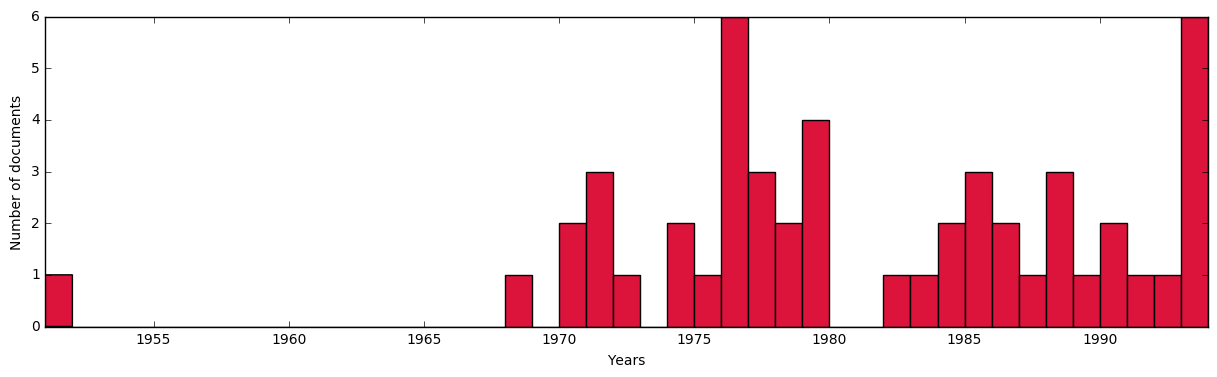

In [49]:
% matplotlib inline
from IPython.display import display, clear_output
from IPython.core.display import HTML
from ipywidgets import widgets, interact, Layout

RES = []

def get_count(ty, query, fields,time):
    """Get the count of a type, query, fields, and time."""
    
    return es.count(index='telegraaf',
                    body={'query':{"filtered":{"query":
                                                  {"multi_match": 
                                                      {"query" : query,
                                                          "type" : "cross_fields",  
                                                          "fields" : fields,
                                                          "operator" : 'and'
                                                       }
                                                  },
                                                  "filter":
                                                      {"bool":
                                                           {"must": 
                                                               [{"term": {"_type": ty}},
                                                                {"range":{"year":{
                                                                   "gte":time[0],
                                                                   "lte":time[1]}}}]
                                                            }
                                                      }
                                              }
                                    }
                         })['count']


# Initialise SERP such that on the first the system doesn't return an error
SERP = ''

# SEARCH FIELD AND BUTTON
text = widgets.Text(placeholder='Vul een zoekterm in')
search_button = widgets.Button(description="Search")

# ADVANCED SEARCH TOGGLE BUTTON
advanced = widgets.ToggleButton(description="Toggle Advanced Search", layout=Layout(background_color=COLOUR),
                                width='220px', button_style='info', value=True)


# INITIAL SEARCHBAR CONTAINER
container = widgets.HBox((widgets.HTML('',width='130px'),
                          widgets.HTML('Zoektermen:'),
                          text, 
                          widgets.HTML(''), 
                          search_button,
                          widgets.HTML('',width='50px'),
                          advanced))
container.layout.align_items='center'

#===================================================================
#                   TEXT FIELDS: CHECKBOXES
#===================================================================

# TEXT FIELD CHECKBOX
text_check = widgets.Checkbox(value=True, width='50px')
textfield = widgets.HBox(children=(widgets.HTML('',width='20px'),
                                   widgets.HTML('Text'),
                                   text_check))
textfield.layout.align_items='center'

# TITLE FIELD CHECKBOX
title_check = widgets.Checkbox(value=True, width='50px')
titlefield = widgets.HBox(children=(widgets.HTML('',width='20px'),
                                    widgets.HTML('Title'),
                                    title_check))
titlefield.layout.align_items='center'

# FINAL CONTAINER
c_textfields = widgets.VBox(children=(widgets.HTML('Welke zoekvelden?'),
                                      textfield, 
                                      titlefield))
titlefield.layout.align_items='center'

#==============================================================
#        DOCUMENT TYPES: CHECKBOXES - TEXT VALUES
#==============================================================

# this should probably be rewritten to not include a class. It's overkill 
# Just setting them as a ??_text should be suficient. 
class doc_widget:
    
    def __init__(self,name,value):
        self.value = value
        self.name = name
        self.widget = widgets.Text(str(self.name)+' ('+str(self.value)+')', 
                                   width='220px', disabled=True) 
        # Disable=True to make sure the user can't change the value
        
    def set_value(self, value):
        self.value = value
        self.widget = widgets.Text(str(self.name)+' ('+str(self.value)+')', 
                                   width='220px', disabled=True)
        # Disable=True to make sure the user can't change the value
        
# THE TEXT VALUES
doc_types = {}
for i in unique_doc_types:
    doc_types[i]  = doc_widget(i,0)

# CHECKBOXES
ad_check = widgets.Checkbox(value=True, width='20px')
ar_check = widgets.Checkbox(value=True, width='20px')
io_check = widgets.Checkbox(value=True, width='20px')
fb_check = widgets.Checkbox(value=True, width='20px')

# FIRST ROW
row1 = widgets.HBox(children=(ad_check,
                              doc_types['advertentie'].widget, 
                              widgets.HTML('',width='20px'),
                              ar_check,
                              doc_types['artikel'].widget))
row1.layout.align_items='center'

# SECOND ROW
row2 = widgets.HBox(children=(io_check,
                              doc_types['illustratie met onderschrift'].widget,
                              widgets.HTML('',width='20px'),
                              fb_check,
                              doc_types['familiebericht'].widget))
row2.layout.align_items='center'

# FINAL CONTAINER 
c_types = widgets.VBox(children=(widgets.HTML('Welke type documenten?'),
                                 row1,
                                 row2))

#================================================================================== 
#                  TIME PERIOD SLIDER - TIMELINE - WORDCLOUD
#==================================================================================

# TIME PERIOD SLIDER
years = widgets.IntRangeSlider(value=[int(unique_years[0]), int(unique_years[-1])], 
                               min=int(unique_years[0]),
                               max= int(unique_years[-1]), 
                               step=1)

# TIMELINE  - WORDCLOUD 
timeline_check = widgets.Checkbox(value=False, width='50px')
wordcloud_check = widgets.Checkbox(value=False, width='50px')
c_extra_options = widgets.HBox(children=(widgets.HTML("Tijdlijn"),
                                         timeline_check, 
                                         widgets.HTML("Wordcloud"), 
                                         wordcloud_check))
c_extra_options.layout.align_items = 'center'
c_extra_options.layout.justify_content = 'center'

# FINAL CONTAINER
c_slide = widgets.VBox(children=(widgets.HTML("Kies tijdsperiode:"), 
                                 years,
                                 c_extra_options
                                ))
#===================================================================== 

# Advanced settings container
container_adv = widgets.HBox((c_textfields,   
                              c_types,       
                              c_slide), )    
container_adv.layout.justify_content = 'space-around'
container_adv.visible=True

#===================================================================== 

def advanced_options(sender):
    if sender['new'] == True:
        container_adv.visible = True
        # Show the advanced settings
        
    elif sender['new'] == False:
        container_adv.visible = False
        # Hide the advanced settings

def show_timeline(sender):
    #res = RES
    if sender['new']==True:
        if timeline_check.value: 
            timeline_years = [hit['_source']['year'] for hit in res['hits']['hits']]
            dates = [hit['_source']['date'] for hit in res['hits']['hits']]   
            if timeline_years != []:
                create_timeline(timeline_years, dates)
    elif sender['new']==False:
        clear_output()
        
#=====================================================================        

def handle_submit(sender):
    """
    This function handles the search after the button has been 
    pressed or the search field has been submitted
    """
    # Define SERP as a global variable, such that for the first 
    # loop it doesn't try to close the non-existing SERP
    global SERP 
    if SERP != '':
        SERP.close()
    clear_output()
    
    # SIMPLE SEARCH
    if container_adv.visible == False:
        display('Zoeken..')
        res = search(text.value)
        clear_output()
        results = result_page(text.value, res['hits']['total'], res['hits']['hits'])
        if results == []:
            SERP = widgets.VBox(children=(widgets.HTML('', height='20px'),
                                          widgets.HTML("<center>Geen zoekresultaten \
                                          zijn gevonden. Probeer het opnieuw</center>")))
        else:            
            pages = []
            page = []
            for i, result in enumerate(results):
                if (i+1) is len(results):
                    page.append(result)
                    pages.append(widgets.VBox(children=tuple(page)))
                elif (i)%10 is 0 and not i is 0:
                    pages.append(widgets.VBox(children=tuple(page)))
                    page = []
                page.append(result)
            
#             SERP = widgets.VBox(children=(tuple([i for i in results])))
#             children = [widgets.Text(description=name) for name in list]
            SERP = widgets.Tab(children=pages)            
        display(SERP)

#----------------------------------------------------------------------------      
    # ADVANCED SEARCH
    else:
        display('Zoeken..')
        
        # SELECTED DOCUMENT TYPES
        types = []
        if ad_check.value:
            types.append('advertentie')
        if ar_check.value:
            types.append('artikel')
        if io_check.value:
            types.append('illustratie met onderschrift')
        if fb_check.value:
            types.append('familiebericht')
        fields = []
        
        # SELECTED TEXT FIELDS
        if title_check.value:
            fields.append('title')
        if text_check.value:
            fields.append('text')
        
        # Search. The values for the slider and text are immediately inputted
        res = search([types,text.value,fields,years.value], advanced=True)
        clear_output()
        results = result_page(text.value, res['hits']['total'], res['hits']['hits'])
        
        # Print the Search results
        if results == []:
            SERP = widgets.VBox(children=(widgets.HTML('', height='20px'),
                                          widgets.HTML("<center>Geen zoekresultaten \
                                          zijn gevonden. Probeer het opnieuw</center>")))
        else:
            pages = []
            page = []
            for i, result in enumerate(results):
                if (i+1) is len(results):
                    page.append(result)
                    pages.append(widgets.VBox(children=tuple(page)))
                elif (i)%10 is 0 and not i is 0:
                    pages.append(widgets.VBox(children=tuple(page)))
                    page = []
                page.append(result)
            SERP = widgets.Tab(children=pages)  
        display(SERP)
        
        # update the type doc numbers
        for i in doc_types:
            doc_types[i].widget.value= doc_types[i].name+' ('+str(get_count(i,text.value,fields,years.value))+')'
        
        # DISPLAY TIMELINE
        if timeline_check.value: 
            timeline_years = [int(hit['_source']['year']) for hit in res['hits']['hits']]
            dates = [hit['_source']['date'] for hit in res['hits']['hits']]   
            if timeline_years != []:
                create_timeline(timeline_years, dates)
        
        #DISPLAY WORDCLOUD
        if wordcloud_check.value:
            total_text = []
            for hit in res['hits']['hits']:
                total_text.extend(hit['_source']['text'].split())
            create_wordcloud(total_text, 50)


        
# Display the main items and set their submits/change response
display(container)
display(container_adv)

# Set the widgets their response 
text.on_submit(handle_submit)
search_button.on_click(handle_submit)
advanced.observe(advanced_options,names='value')

# Update once a checkbox/slider changes

    # Zoekvelden
    
    
    # Doc Types
    
    # Tijdsperiode

    # Tijdlijn
#timeline_check.observe(show_timeline, names='value')
    # Wordcloud


## Evaluation

* Manual relevance check
* P@10
* Change the ranking of the system + explain what is going on and why it is improving/decreasing

Evaluate your results Let 2 persons assess the relevancy of the top 10 documents for 5 different queries. Compute Cohen's kappa. Determine the average precision at 10 for your system based on these 10 queries, and the two relevance assesments. Also plot the P@10 (for both judges) for each query, showing differences in hard and easy queries. Describe clearly how you solved differences in judgements. 
So, both provide the actual query, and a description of the information need that was behind the query.
Give a small set of clear guidelines for judging the results, and let your judges follow these guidelines.
It is far more interesting to have difficult queries (both for the search engine and for the judges) than to have queries on which all ten retrieved documents are relevant. So, try to create a good list of information needs.


In [105]:
from __future__ import division

def cohens_kappa(bins):
    """
    Given bins made by bin_evaluations, returns cohen\'s kappa
    """
    
    total = bins[0]+bins[1]+bins[2]+bins[3]
    po = (bins[0]+bins[3]) / total
    
    marginala = ((bins[3] + bins[2]) * (bins[3] + bins[1])) / total
    marginalb = ((bins[0] + bins[1]) * (bins[0] + bins[2])) / total
    pe = (marginala + marginalb) / total
    
    cohens_kappa = (po - pe) / (1 - pe)
    return cohens_kappa
    
def precision(bins, agreement_necessary):
    """
    Given bins made by bin_evaluations, returns precision
    If second argument is True, document is only seen as
    relevant if both judges think so; otherwise one of the 
    judges is enough
    """
    if agreement_necessary:
        correct = bins[3]
    else:
        correct = bins[3] + bins[2] + bins[1]
    total = bins[0]+bins[1]+bins[2]+bins[3]
    return correct/total
    
    
def bin_evaluations(evaluations):
    """
    Given a list of tuples of binary values which contain
    relevance judgements by two judges in which 1 means 
    relevant, and 0 means non-relevant, returns a list
    in which the 4 elements represent the amount of times
    any combination has occurred.
    """
    
    # bins are 00, 01, 10, 11 in that order
    bins = [0,0,0,0]
    for evaluation in evaluations:
        b = 0
        if evaluation[0]:
            b += 2
        if evaluation[1]:
            b += 1
        bins[b] += 1
    return bins

In [27]:
def evaluate_search_results(number_of_queries):
    """
    Asks the user to submit a query using query_database() some amount 
    of times after which two judges can give their relevancy 
    assessments. Returns evaluations in a format that can be used for 
    bin_evaluations.
    """

    print('After the query is resolved, you will be asked to rate the documents on relevancy.')
    print('To do this, enter the numbers of the relevant results sperated by whitespace.')
    print('For example, if only the first and third documents were relevant, enter \'1 3\' without the quotes.')
    print('If more than ten documents are returned, ignore all but the first 10.\n')
    evaluations = []
    for _ in range(number_of_queries):
        query = raw_input('Query -->')#.split()
        years  =raw_input('Years begin, end -->').split(', ')
        years = tuple(years)
        types = raw_input('Types artikel, advertentie, familiebericht, illustratie met onderschrift -->').split(', ')
        fields = raw_input('Fields text, title -->').split(', ')
        res = search([types,query,fields,years],advanced=True)
        results = result_page(text.value, res['hits']['total'], res['hits']['hits'])
        
        # Print the Search results
        if results == []:
            SERP = widgets.VBox(children=(widgets.HTML('', height='20px'),
                                          widgets.HTML("<center>Geen zoekresultaten \
                                          zijn gevonden. Probeer het opnieuw</center>")))
        else:            
            pages = []
            page = []
            for i, result in enumerate(results):
                if (i+1) is len(results):
                    page.append(result)
                    pages.append(widgets.VBox(children=tuple(page)))
                elif (i)%30 is 0 and not i is 0:
                    pages.append(widgets.VBox(children=tuple(page)))
                    page = []
                page.append(result)
            
            SERP = widgets.Tab(children=pages)            
        display(SERP)
        
        print('Indicate which documents were relevant:')
        judge1_input = raw_input('Judge 1 -->').split()
        judge2_input = raw_input('Judge 2 -->').split()
        for i in range(1, 11):
            if str(i) in judge1_input:
                assessment1 = 1
            else:
                assessment1 = 0
            if str(i) in judge2_input:
                assessment2 = 1
            else:
                assessment2 = 0
            evaluations.append((assessment1, assessment2))
    
    bins = bin_evaluations(evaluations)
    print('\nThe average P@10 if we require agreement for correctness: ' + str(precision(bins, 1)))
    print("The average P@10 if we require a single \'relevant\' assessment for correctness: " + str(precision(bins, 0)))
    print("Cohen\'s Kappa was: " +str(cohens_kappa(bins)))
    return evaluations

In [31]:
evaluations = evaluate_search_results(1)